# Competition 2. Marketing Campaign

## Challenge Overview

You are running the marketing campaign for a brand new pocket device. Initially you can sign contracts with a few people to advertize your gadget among their neigbours. The more "famous" person you are picking the greater price appears in the contract. Contract cost can be calculated as 300 \$ * NN(i), where NN(i) is the number of neigbours of the person i. If at least 18% a person's neighbors have already been affected, then he/she will also be affected tomorrow. You earn 50 \$ per each affected person. Every day you have to choose whether to sign new contracts or wait. You need time to discuss terms of a contract, so you cannot sign more than 10 contracts on the same day. Your task is to maximize profit of your campaign with an initial budget of 10,000\$. Your campaign is considered completed after 60 days.

Again, all parameters of the task:
- Budget: 10,000\$
- Contract cost: 300\$ * NN(i)
- Income per person: 50\$
- Exposure threshold: 18%
- Contracts limit: 10 per day
- Time limit: 60 days

A model of society is based on undirected SNAP Facebook network edge_list.txt

##Evaluation Criteria

On the leaderboard you will see three scores:
- Profit — calculated as "total amount of money at the end - initial budget". This is the main score.
- Accepted — the total number of accepted people at the end.
- Days — the total duration of your campaign.

__Baselines__

Baselines are calculated as follows:

- Simultaneously sign 10 random contracts on the first day. Decrease the number of contracts if you do not have enough money
- Wait the end of the campaign and calculate your profit.
- Repeat 10000 times

Baseline for grade 4: beat an average positive profit

Baseline for grade 6: beat an average + standard deviation positive profit

# Решение

_Комментарии_:
- везде далее активированные вручную вершины обозначаются <font color='yellow'>желтым</font>, активированные из-за соседей <font color='red'>красным</font>, а неактивированные белым
- некоторые ячейки могут работать час, а то и больше, это нормально

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import requests
import json
import imageio
import os
from tqdm import tqdm
from pprint import pprint

In [13]:
params = {
    'budget': 10000,
    'contract_cost': 300,
    'income_per_person': 50,
    'exposure_threshold': 0.18,
    'contracts_limit': 10,
    'time_limit': 60
}

In [15]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/made-2022/competition_marketing_campaign/edge_list.txt'
open('edge_list.txt', 'wb').write(requests.get(url).content)

G = nx.read_edgelist("edge_list.txt", nodetype=int)

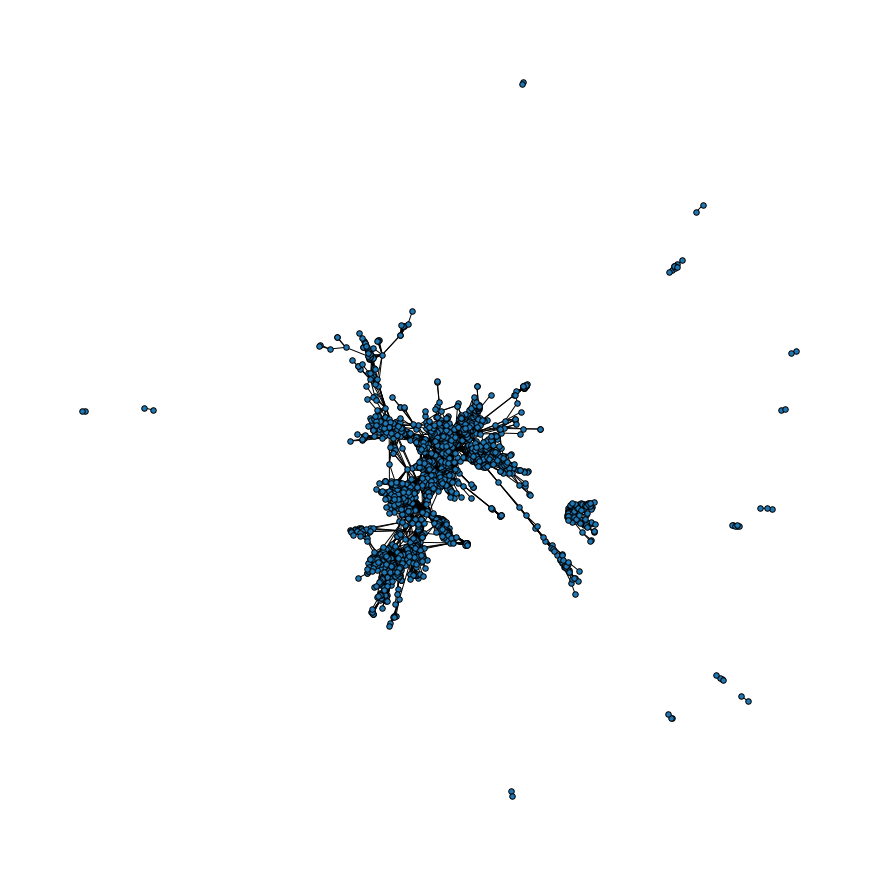

In [4]:
plt.figure(figsize=(12, 12))

nx.draw(G,
        node_size=30,
        edgecolors='black',
        linewidths=1)

Посмотрим на размеры компонент связности

In [16]:
connected_components = sorted([g for g in nx.connected_components(G)], key=len)
print(*[len(g) for g in connected_components])

2 2 2 2 2 2 2 2 3 3 4 6 9 180 3732


Очевидно, что маленькие компоненты связности рассматривать невыгодно. Оставим только самую большую

In [17]:
G = G.subgraph(connected_components[-1])

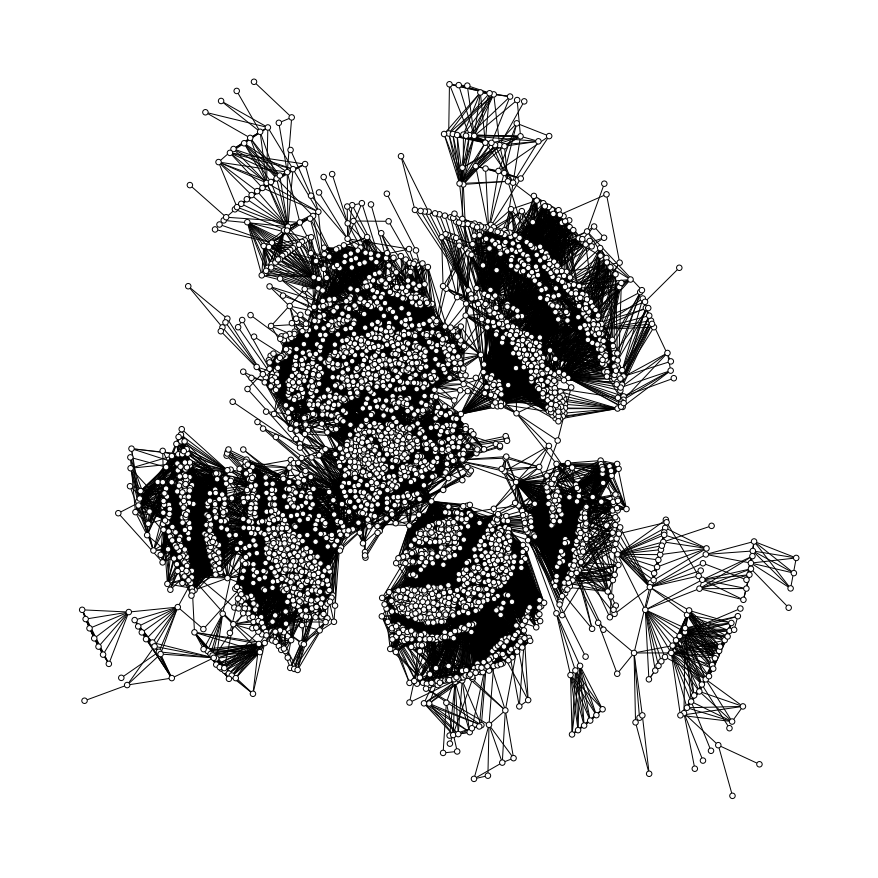

In [18]:
plt.figure(figsize=(12, 12))

pos = nx.kamada_kawai_layout(G)

for node in G.nodes:
    G.nodes[node]['color'] = 'white'
node_color = list(nx.get_node_attributes(G, 'color').values())

nx.draw(G,
        pos=pos,
        node_size=30,
        node_color=node_color,
        edgecolors='black',
        linewidths=1)

In [19]:
def get_percent_of_affected_nodes(G, node):
    '''Функция для подсчета процента активированных соседей вершины'''
    neighbors = list(G.neighbors(node))
    amount = sum([1 if G.nodes[node]["color"] != "white" else 0 for node in neighbors])
    return amount / len(neighbors)

In [20]:
def update_graph_after_activate_nodes(graph, activate_nodes, params=params, return_G=True, return_profit=False, return_profitability=False):
    '''Функция для моделирования активации вершин в графе

    activate_nodes - целое число или список вершин графа
    return_G - возвращает граф
    return_profit - возвращает профит, полученный после активации вершин
    return_profitability - возвращает доходность, то есть профит, отнормированный
    на степень активированной вершины (работает только для одной вершины)
    '''

    G = graph.copy()
    profit = 0
    prev_profit = -1

    if isinstance(activate_nodes, int):
        activate_nodes = [activate_nodes]

    for node in activate_nodes:
        G.nodes[node]["color"] = 'red'
        profit -= params['contract_cost'] * G.degree[node]

    for day in range(params['time_limit']):
        
        affected_nodes = set()
        for node in G.nodes:
            if get_percent_of_affected_nodes(G, node) >= params['exposure_threshold'] and G.nodes[node]["color"] != "red":
                affected_nodes.add(node)
        
        for node in affected_nodes:
            profit += params['income_per_person']
            G.nodes[node]["color"] = "red"
        
        if profit == prev_profit:
            break
        else:
            prev_profit = profit

    if return_G and return_profit:
        return G, profit

    elif return_G and return_profitability:
        return G, profit / (params['contract_cost'] * G.degree[activate_nodes[0]])

    elif return_profit and return_profitability:
        return profit, profit / (params['contract_cost'] * G.degree[activate_nodes[0]])

    elif return_G:
        return G
    
    elif return_profit:
        return profit

    elif return_profitability:
        return profit / (params['contract_cost'] * G.degree[activate_nodes[0]])

In [21]:
def calculate_profit(graph, strategy, pos=pos, params=params, draw_graph=True, draw_profit=True):
    '''Функция отрисовывает граф и динамику профита при данной стратегии активации вершин'''
    G = graph.copy()
    budget = params['budget']

    history = []
    num_affected = 0

    for day in range(params['time_limit']):
        if day in strategy.keys():
            for node in strategy[day]:
                G.nodes[node]["color"] = 'yellow'
                num_affected += 1
                budget -= params['contract_cost'] * G.degree[node]

        affected_nodes = set()
        for node in G.nodes:
            if get_percent_of_affected_nodes(G, node) >= params['exposure_threshold'] and G.nodes[node]["color"] == 'white':
                affected_nodes.add(node)

        for node in affected_nodes:
            budget += params['income_per_person']
            G.nodes[node]["color"] = "red"
            num_affected += 1
        history.append(budget - params["budget"])

    print('Strategy: ')
    pprint(strategy)
    if draw_graph and draw_profit:
        plt.figure(figsize=(16, 8))
    else:
        plt.figure(figsize=(12, 12))
        
    if draw_graph:
        if draw_profit:
            plt.subplot(121)
        node_color = list(nx.get_node_attributes(G, 'color').values())
        nx.draw(G,
                pos=pos,
                node_size=30,
                node_color=node_color,
                edgecolors='black',
                linewidths=1)
        plt.title(f'Affected = {num_affected}')
        
    if draw_profit:
        if draw_graph:
            plt.subplot(122)
        plt.plot(history, color='black')
        plt.title(f'Profit = {history[-1]}')
        plt.hlines(-params['budget'], 0, params['time_limit'], color='red')
        plt.grid()
    
    plt.show()

Посчитаем профит и доходность каждой вершины, если в графе активировать только ее

In [11]:
profitability_by_nodes = dict()
profit_by_nodes = dict()

for x in tqdm(G.nodes):
    profit_by_nodes[x], profitability_by_nodes[x] = update_graph_after_activate_nodes(G,
                                                                                      activate_nodes=x,
                                                                                      return_G=False,
                                                                                      return_profit=True,
                                                                                      return_profitability=True)

100%|██████████| 3732/3732 [1:09:11<00:00,  1.11s/it]


In [12]:
sorted(profit_by_nodes.items(), key=lambda x: x[1])[-10:]

[(2217, 7200),
 (2450, 7500),
 (2113, 8100),
 (2439, 8100),
 (2548, 8700),
 (2263, 9000),
 (2528, 9000),
 (1505, 17900),
 (3057, 30200),
 (1304, 32000)]

In [13]:
sorted(profitability_by_nodes.items(), key=lambda x: x[1])[-10:]

[(2217, 2.0),
 (2450, 2.272727272727273),
 (3991, 2.6666666666666665),
 (1304, 2.8828828828828827),
 (2113, 3.0),
 (2439, 3.0),
 (2548, 4.142857142857143),
 (2263, 5.0),
 (2528, 5.0),
 (3057, 6.291666666666667)]

Это можно интерпретировать так:
- При активации только вершины 1304 мы получаем профит равный 32000
- При активации вершины 3057 ее стоимость окупается в 6.3 раза

In [22]:
def search_strategy(graph, nodes_0):
    '''Функция жадного поиска стратегии активации вершин
    
    nodes_0 - список вершин, которые активируются в начале
    Возвращает список вершин, которые максимизируют профит
    '''
    G = graph.copy()
    G = update_graph_after_activate_nodes(G, nodes_0)
    
    max_profit = 1
    result = nodes_0

    while max_profit > 0:
        profit_by_nodes = dict()

        for node in tqdm(G.nodes):
            if G.nodes[node]["color"] == 'red':
                continue
            profit_by_nodes[node] = update_graph_after_activate_nodes(G,
                                                                      activate_nodes=node,
                                                                      return_G=False,
                                                                      return_profit=True,
                                                                      return_profitability=False)
        
        max_node = max(profit_by_nodes.items(), key=lambda x: x[1])[0]        
        max_profit = profit_by_nodes[max_node]
        result.append(max_node)
        G = update_graph_after_activate_nodes(G, max_node)

    return result

Попробуем жадным алгоритмом искать стратегии с разными начальными вершинами (самыми лучшими по доходу и доходности)

100%|██████████| 3732/3732 [05:27<00:00, 11.41it/s]


Strategy: 
{0: [3057, 1304, 3775, 2263, 2568, 1084, 54, 2745, 167, 154, 894]}


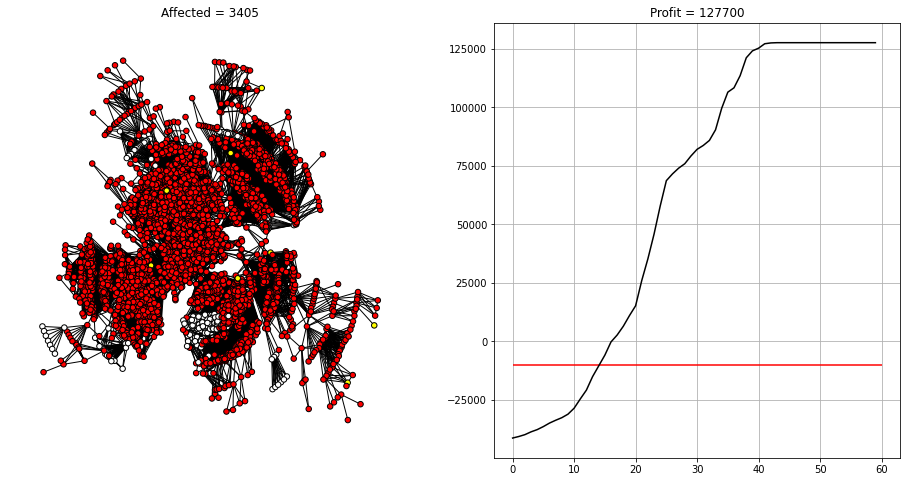

In [11]:
strategy = search_strategy(G, [3057])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [05:27<00:00, 11.40it/s]


Strategy: 
{0: [2528, 1304, 996, 3775, 2568, 1084, 54, 2745, 167, 154, 894]}


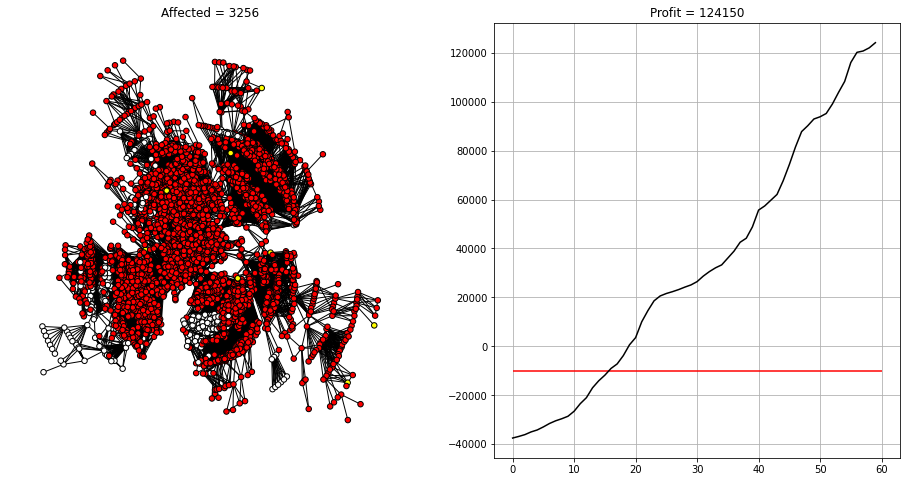

In [12]:
strategy = search_strategy(G, [2528])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [05:21<00:00, 11.60it/s]


Strategy: 
{0: [2263, 1304, 996, 3775, 2568, 1084, 54, 2745, 167, 154, 894]}


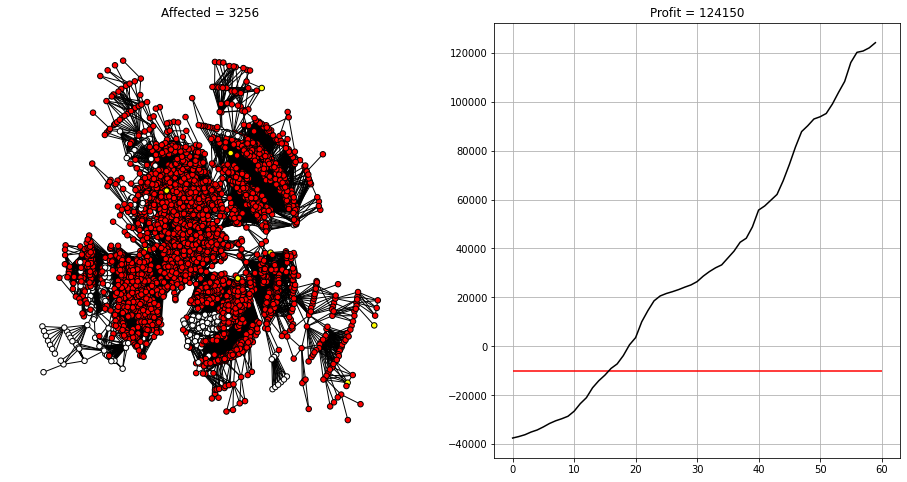

In [13]:
strategy = search_strategy(G, [2263])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [04:55<00:00, 12.65it/s]


Strategy: 
{0: [2548, 1304, 996, 3775, 2568, 1084, 54, 2745, 167, 154, 894]}


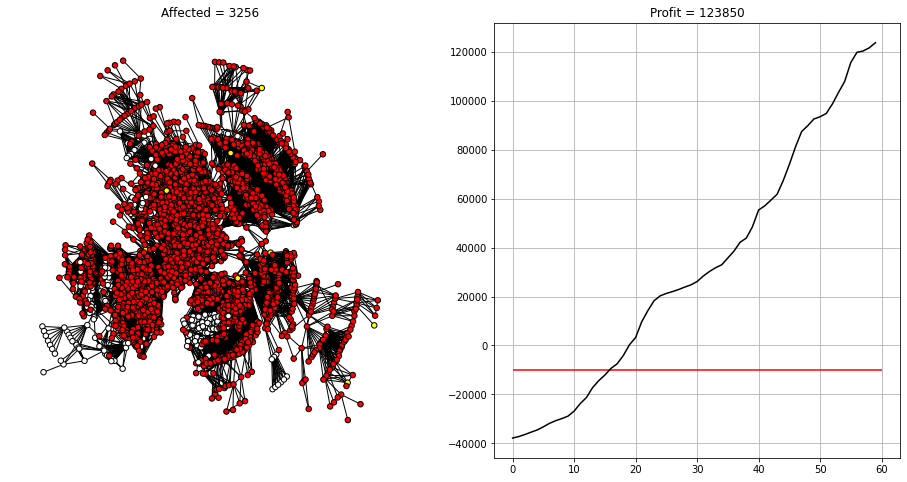

In [11]:
strategy = search_strategy(G, [2548])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [04:41<00:00, 13.27it/s]


Strategy: 
{0: [1304, 996, 3775, 2263, 2568, 1084, 54, 2745, 167, 154, 894]}


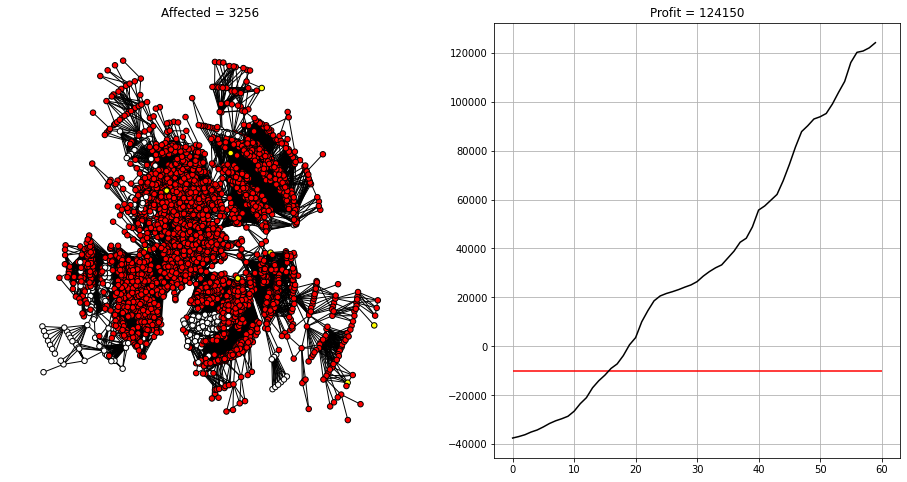

In [11]:
strategy = search_strategy(G, [1304])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [04:36<00:00, 13.49it/s]


Strategy: 
{0: [1505, 1304, 3775, 2263, 2568, 1084, 54, 2745, 167, 154, 894]}


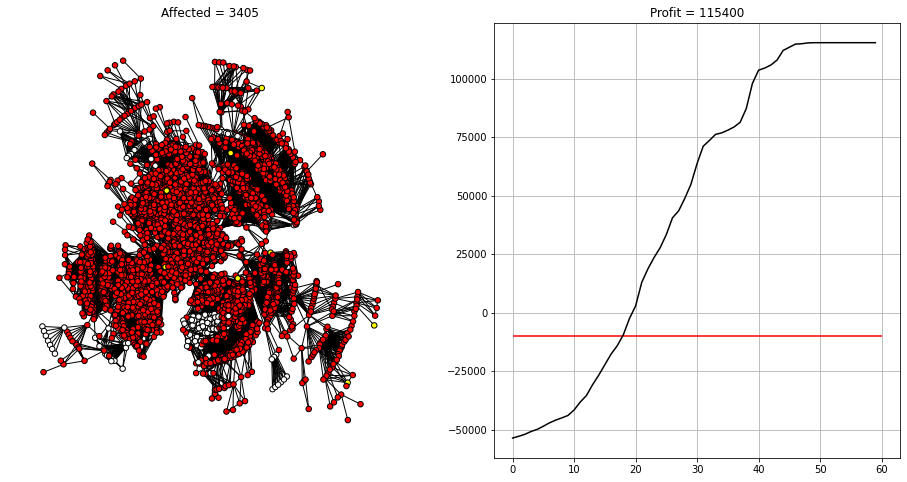

In [12]:
strategy = search_strategy(G, [1505])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [04:40<00:00, 13.29it/s]


Strategy: 
{0: [2528, 1304, 996, 3775, 2568, 1084, 54, 2745, 167, 154, 894]}


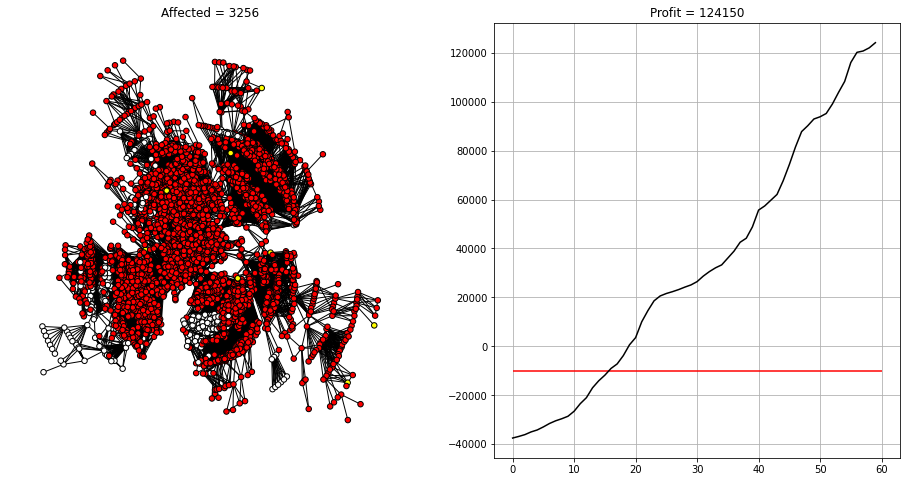

In [13]:
strategy = search_strategy(G, [2528])
calculate_profit(G, {0: strategy})

100%|██████████| 3732/3732 [04:17<00:00, 14.50it/s]


Strategy: 
{0: [2548, 1304, 996, 3775, 2568, 1084, 54, 2745, 167, 154, 894]}


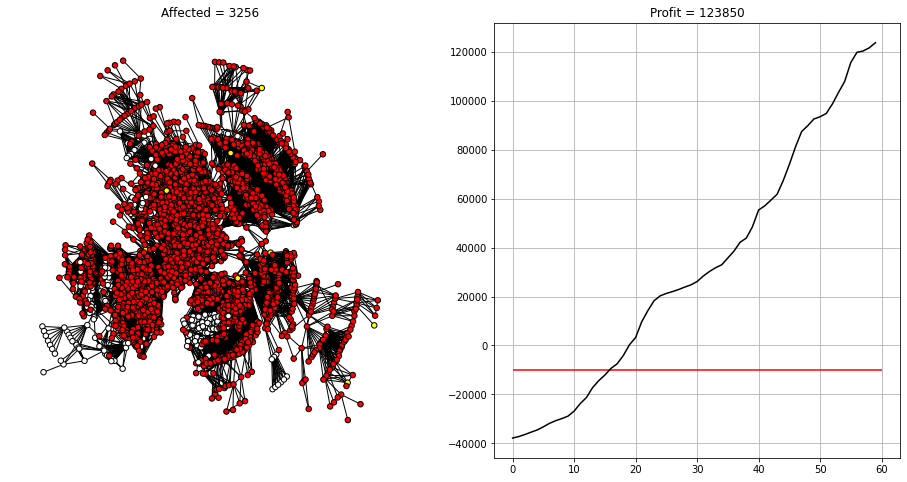

In [11]:
strategy = search_strategy(G, [2548])
calculate_profit(G, {0: strategy})

Масимальный профит, который получилось добиться таким подходом, равен __127700__

Ручным подбором вершин из различных стратегий, полученных жадным поиском выше, и заменой дорогих вершин на некоторое число ее соседей, чья суммарная стоимость меньше стоимости оригинальной вершины, удалось поднять профит до __131450__

Strategy: 
{0: [1248,
     3808,
     1474,
     129,
     2788,
     167,
     3432,
     2568,
     1103,
     1264,
     3953,
     2678,
     2263,
     2745,
     154,
     347,
     1084,
     1759]}


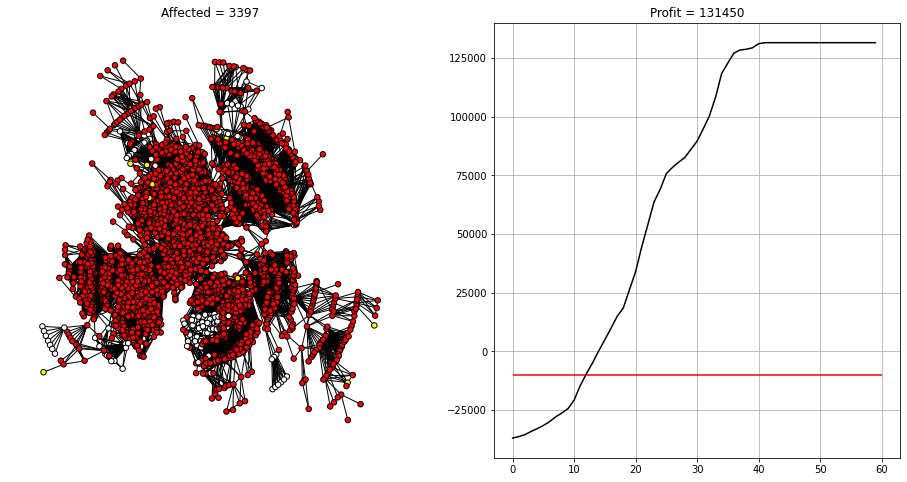

In [27]:
strategy = {0: [1248, 3808, 1474, 129, 2788, 167, 3432, 2568, 1103, 1264, 3953, 2678, 2263, 2745, 154, 347, 1084, 1759]}
calculate_profit(G, strategy)

Далее осталось только распределить вершины по дням так, чтобы стратегия удовлетворяла условиям задачи. Хотя это и можно сделать автоматически, это также и несложно сделать вручную

Strategy: 
{0: [1103, 167, 2263, 2568, 3808],
 4: [129],
 6: [154],
 7: [3432],
 8: [2788, 347],
 11: [1248],
 12: [1264, 1474, 1759],
 14: [2678],
 15: [3953],
 20: [1084],
 27: [2745]}


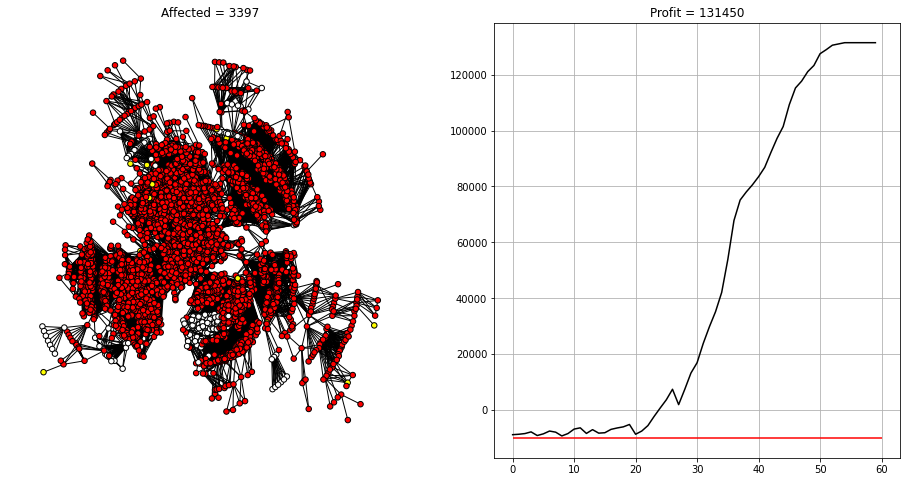

In [23]:
final_strategy = {0: [1103, 167, 2263, 2568, 3808],
                  4: [129],
                  6: [154],
                  7: [3432],
                  8: [2788, 347],
                  11: [1248],
                  12: [1264, 1474, 1759],
                  14: [2678],
                  15: [3953],
                  20: [1084],
                  27: [2745]}

calculate_profit(G, final_strategy)

Сохраним полученную стратегию в файл

In [29]:
submit = '''{0: [1103, 167, 2263, 2568, 3808],
            4: [129],
            6: [154],
            7: [3432],
            8: [2788, 347],
            11: [1248],
            12: [1264, 1474, 1759],
            14: [2678],
            15: [3953],
            20: [1084],
            27: [2745]}'''

with open('submit.txt', 'w') as f:
    f.write(submit)

Для красоты: [гифка](https://drive.google.com/file/d/1bglIsMtNaS4EPVFfXkmgjmrQMo6eorTY/view?usp=sharing), которая показывает как активируются вершины

![](https://drive.google.com/uc?export=view&id=1bglIsMtNaS4EPVFfXkmgjmrQMo6eorTY)

In [30]:
def gif_graph(graph, strategy, params=params, pos=pos):
    G = graph.copy()
    budget = params['budget']

    history = []
    filenames = []
    num_affected = 0

    for day in range(params['time_limit']):
        if day in strategy.keys():
            for node in strategy[day]:
                G.nodes[node]["color"] = 'yellow'
                num_affected += 1
                budget -= params['contract_cost'] * G.degree[node]

        affected_nodes = set()
        for node in G.nodes:
            if get_percent_of_affected_nodes(G, node) >= params['exposure_threshold'] and G.nodes[node]["color"] == 'white':
                affected_nodes.add(node)

        for node in affected_nodes:
            budget += params['income_per_person']
            G.nodes[node]["color"] = "red"
            num_affected += 1
        history.append(budget - params["budget"])

        node_color = list(nx.get_node_attributes(G, 'color').values())
        plt.figure(figsize=(12, 12))
        plt.title(f'day = {day + 1}, affected = {num_affected}, profit = {history[-1]}')
        nx.draw(G,
                pos=pos,
                node_size=30,
                node_color=node_color,
                edgecolors='black',
                linewidths=1);
        plt.savefig(f'{day}.png')
        plt.close() 
        filenames.append(f'{day}.png')

    with imageio.get_writer('marketing_graph.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    for filename in set(filenames):
        os.remove(filename)

In [31]:
gif_graph(G, final_strategy)